In [1]:
!python -V

Python 3.9.23


In [2]:
import pandas as pd 

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/08/27 11:26:15 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/27 11:26:15 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/MLOps/02-experiment-tracking/mlruns/1', creation_time=1756198980276, experiment_id='1', last_update_time=1756198980276, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet')

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [9]:
df.shape


(1369769, 19)

In [10]:
# Use only 100k rows for training (enough to test pipeline)
df_sample = df.sample(n=100000, random_state=42)
# Ensure datetime conversion
df_sample.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(df_sample['tpep_dropoff_datetime'])
df_sample.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(df_sample['tpep_pickup_datetime'])

# Duration in minutes (vectorized, no apply)
df_sample.loc[:, 'duration'] = (df_sample['tpep_dropoff_datetime'] - df_sample['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter rows (returns a copy, so reassign)
df_sample = df_sample.loc[(df_sample['duration'] >= 1) & (df_sample['duration'] <= 60)].copy()

# Cast categorical
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_sample.loc[:, categorical] = df_sample[categorical].astype(str)



/tmp/ipykernel_62541/1989128297.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['170' '100' '166' ... '7' '68' '229']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sample.loc[:, categorical] = df_sample[categorical].astype(str)
/tmp/ipykernel_62541/1989128297.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['237' '142' '231' ... '163' '229' '141']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sample.loc[:, categorical] = df_sample[categorical].astype(str)


In [11]:


train_dicts = df_sample[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df_sample['duration'].values


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

45.911538072055265

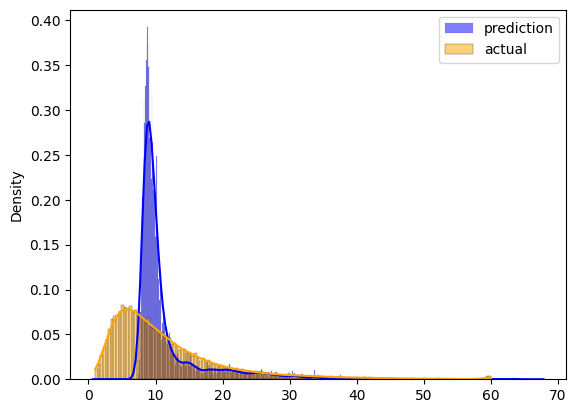

In [12]:
sns.histplot(y_pred, label='prediction', color='blue', kde=True, stat="density")
sns.histplot(y_train, label='actual', color='orange', kde=True, stat="density")
plt.legend()


In [13]:
def read_dataframe(filename):
    cols = [
        "tpep_pickup_datetime", 
        "tpep_dropoff_datetime", 
        "PULocationID", 
        "DOLocationID", 
        "trip_distance"
    ]

    if filename.endswith('.csv'):
        df = pd.read_csv(filename, usecols=cols)

    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename, columns=cols)

    else:
        raise ValueError("Unsupported file format: must be .csv or .parquet")

    # Convert to datetime
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

    # Duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Filter reasonable trips
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)].copy()

    # Categorical columns as string
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


In [14]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet').sample(100000, random_state=42)
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet').sample(50000, random_state=42)

In [15]:
len(df_train), len(df_val)

(100000, 50000)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

31.71250270874778

In [20]:
import os
import pickle

# Make sure folder exists
os.makedirs("models", exist_ok=True)

# Save model + vectorizer
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)
mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")    
mlflow.end_run()

In [21]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Sidhu")
    mlflow.log_param("train_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")
    mlflow.log_param("test_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("mse", mse)
   

In [22]:
import xgboost as xgb

In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, 'validation')],
            early_stopping_rounds=20
        )
        y_pred = booster.predict(valid)
        mse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("mse", mse)

    return {'loss': mse, 'status': STATUS_OK}

In [26]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 12, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, -1),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:squarederror',
#     'seed': 42
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=15,
#     trials=Trials()
# )

In [29]:

params = {
    "learning_rate": 0.15848506129885845,
    "max_depth": 15,
    "min_child_weight": 2.1041980108484264,
    "objective": "reg:squarederror",
    "reg_alpha": 0.008840493913711273,
    "reg_lambda": 0.002917480412712516,
    "seed": 42
}

with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
        # log all params
    for key, value in params.items():
        mlflow.log_param(key, value)
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, 'validation')],
        early_stopping_rounds=20
    )
        # evaluate
    preds = booster.predict(valid)
    mse = mean_squared_error(y_val, preds)
    mlflow.log_metric("mse", mse)

    # log the model
    mlflow.xgboost.log_model(
        booster,
        name="xgboost-model",  # MLflow 2.9+ prefers `name` over artifact_path)
    )

[0]	validation-rmse:8.33911
[1]	validation-rmse:7.59997
[2]	validation-rmse:7.02126
[3]	validation-rmse:6.56960
[4]	validation-rmse:6.22045
[5]	validation-rmse:5.95425
[6]	validation-rmse:5.74852
[7]	validation-rmse:5.59488
[8]	validation-rmse:5.47616
[9]	validation-rmse:5.38550
[10]	validation-rmse:5.31611
[11]	validation-rmse:5.26223
[12]	validation-rmse:5.22056
[13]	validation-rmse:5.18886
[14]	validation-rmse:5.16090
[15]	validation-rmse:5.13916
[16]	validation-rmse:5.12290
[17]	validation-rmse:5.10794
[18]	validation-rmse:5.09544
[19]	validation-rmse:5.08324
[20]	validation-rmse:5.07482
[21]	validation-rmse:5.06882
[22]	validation-rmse:5.06222
[23]	validation-rmse:5.05939
[24]	validation-rmse:5.05804
[25]	validation-rmse:5.05371
[26]	validation-rmse:5.05302
[27]	validation-rmse:5.04977
[28]	validation-rmse:5.04883
[29]	validation-rmse:5.04842
[30]	validation-rmse:5.04742
[31]	validation-rmse:5.04440
[32]	validation-rmse:5.04391
[33]	validation-rmse:5.04245
[34]	validation-rmse:5.0

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/08/27 11:28:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# mlflow.xgboost.log_model(booster, name="model")

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")
        mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet")
        

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("mse", mse)

: 